In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM
from tensorflow.keras.optimizers import RMSprop
plt.style.use('seaborn')

# [4월 19일]
---

## # 기온 예측
---

### # 날씨 데이터 불러오기
---

In [ ]:
df_weather = pd.read_csv('/content/drive/MyDrive/workspace/cakd5/m9_딥러닝 알고리즘 구현/data/jena_climate/jena_climate_2009_2016.csv')
display(df_weather.head())

float_data = df_weather.iloc[:, 1:].values
float_data, float_data.shape

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


(array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
          1.7500e+00,  1.5230e+02],
        [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
          1.5000e+00,  1.3610e+02],
        [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
          6.3000e-01,  1.7160e+02],
        ...,
        [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
          2.0000e+00,  2.1520e+02],
        [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
          2.1600e+00,  2.2580e+02],
        [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
          1.9600e+00,  1.8490e+02]]), (420551, 14))

In [ ]:
import os

data_dir = '/content/drive/MyDrive/workspace/cakd5/m9_딥러닝 알고리즘 구현/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
# 데이터 파싱

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

float_data, float_data.shape

(array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
          1.7500e+00,  1.5230e+02],
        [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
          1.5000e+00,  1.3610e+02],
        [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
          6.3000e-01,  1.7160e+02],
        ...,
        [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
          2.0000e+00,  2.1520e+02],
        [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
          2.1600e+00,  2.2580e+02],
        [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
          1.9600e+00,  1.8490e+02]]), (420551, 14))

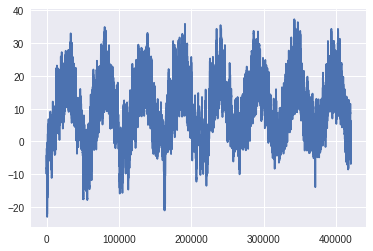

In [ ]:
# 시계열 온도 그래프

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

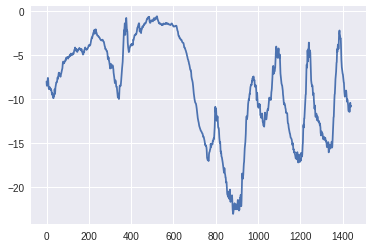

In [ ]:
# 처음 10일간의 온도 그래프

plt.plot(range(1440), temp[:1440])
plt.show()

## # 데이터 전처리
---

### # 데이터 정규화
---

In [ ]:
# 표준화

mean = float_data[:200000].mean(axis = 0)
std = float_data[:200000].std(axis = 0)
float_data -= mean
float_data /= std

### # 시계열 데이터와 타겟을 반환하는 제네레이터 함수
---
* `data` : 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.
* `steps_per_epoch * batch_size` = 훈련 샘플 수

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### # 훈련, 검증, 테스트 제네레이터 준비
---

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
# generator() 함수는 while문을 사용하여 무한 반복되기 때문에 검증 세트와 테스트 세트를 한 번 순회하는 횟수를 알려주어야 한다.
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## # 기본적인 완전 연결 모델 구성
---
- 상식적인 수준의 오차 기준점인 MAE 0.29보다 좋지 않다.
- 시계열 변화의 정보를 제대로 반영하지 못하고 있다.
- 문제에 맞는 데이터와 모델 구성이 중요하다.

In [ ]:
# 모델 훈련 및 평가

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.2825 - val_loss: 0.4189
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.3595 - val_loss: 0.3402
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2854 - val_loss: 0.3369
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2634 - val_loss: 0.3260
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2510 - val_loss: 0.3285
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2424 - val_loss: 0.3147
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2357 - val_loss: 0.3369
Epoch 8/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2300 - val_loss: 0.3233
Epoch 9/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2274 - val_loss: 0.3203
Epoch 10/20
500/500 [==============================] - 11s 21ms/step - loss: 0.223

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3360)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                107552    
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


930/930 [==============================] - 8s 8ms/step - loss: 1.0503


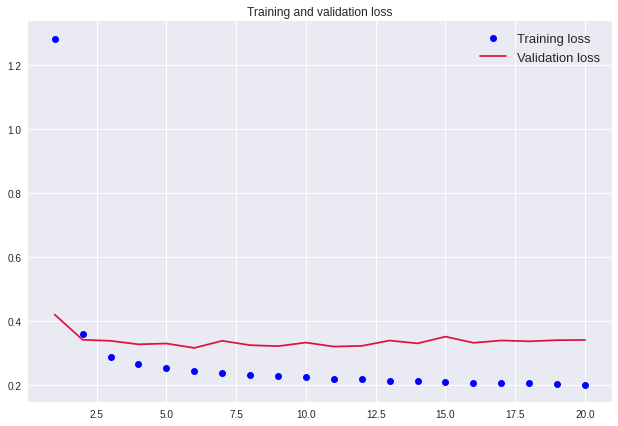

In [ ]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

## # LSTM 모델 구성
---

In [ ]:
# 모델 훈련 및 평가

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(32, input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 19s 30ms/step - loss: 0.3071 - val_loss: 0.2705
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2766 - val_loss: 0.2684
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2663 - val_loss: 0.2784
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2532 - val_loss: 0.2722
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2487 - val_loss: 0.2806
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2398 - val_loss: 0.2807
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2342 - val_loss: 0.2894
Epoch 8/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2265 - val_loss: 0.2928
Epoch 9/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2200 - val_loss: 0.3007
Epoch 10/20
500/500 [==============================] - 14s 28ms/step - loss: 0.214

930/930 [==============================] - 9s 10ms/step - loss: 0.3410


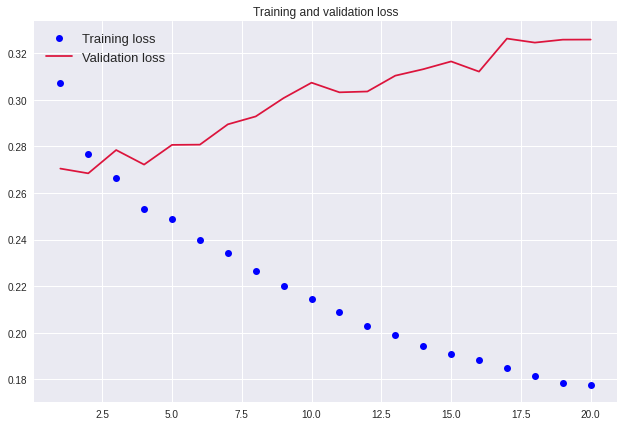

In [ ]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

## # GRU 모델 구성
---

#### # 조건 없는 GRU 모델
---

In [ ]:
# 모델 훈련 및 평가

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 15s 27ms/step - loss: 0.2994 - val_loss: 0.2714
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2842 - val_loss: 0.2659
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2768 - val_loss: 0.2625
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2735 - val_loss: 0.2637
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2692 - val_loss: 0.2665
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2642 - val_loss: 0.2656
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2578 - val_loss: 0.2650
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2547 - val_loss: 0.2698
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2525 - val_loss: 0.2681
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.249

930/930 [==============================] - 9s 9ms/step - loss: 0.3171


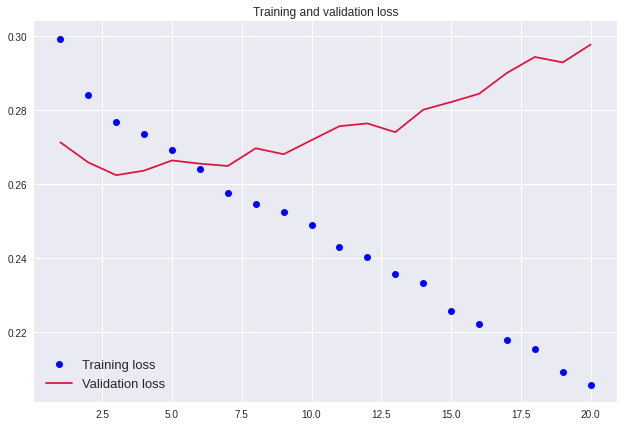

In [ ]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

### # 과대적합을 감소하기 위해 순환 드롭아웃 사용
---
- recurrent_dropout : 순환 상태의 드롭아웃 비율
- input_t에 dropout 비율이 적용
- state_t에 recurrent_dropout 비율이 적용
- 각각의 input_t와 state_t에 서로 다른 드롭아웃 마스크가 적용된다.

#### # 드롭아웃만 사용
---
- 30번째 에포크까지 과대적합이 일어나지 않는다.

In [ ]:
# 모델 훈련 및 검증

model = Sequential()
model.add(GRU(32, 
              dropout = 0.2, 
              recurrent_dropout = 0.2,
              input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 40,
                    validation_data = val_gen,
                    validation_steps = val_steps)

In [ ]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

In [ ]:
# 모델 훈련 및 검증
# 에폭 20으로 잘못 돌림

model = Sequential()
model.add(GRU(32, 
              dropout = 0.2, 
              recurrent_dropout = 0.2,
              input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 457s 906ms/step - loss: 0.3302 - val_loss: 0.2869
Epoch 2/20
500/500 [==============================] - 442s 885ms/step - loss: 0.3058 - val_loss: 0.2991
Epoch 3/20
500/500 [==============================] - 445s 890ms/step - loss: 0.3023 - val_loss: 0.2821
Epoch 4/20
500/500 [==============================] - 443s 886ms/step - loss: 0.2954 - val_loss: 0.2764
Epoch 5/20
500/500 [==============================] - 442s 885ms/step - loss: 0.2935 - val_loss: 0.2708
Epoch 6/20
500/500 [==============================] - 447s 893ms/step - loss: 0.2899 - val_loss: 0.2691
Epoch 7/20
500/500 [==============================] - 450s 900ms/step - loss: 0.2858 - val_loss: 0.2694
Epoch 8/20
500/500 [==============================] - 438s 877ms/step - loss: 0.2853 - val_loss: 0.2696
Epoch 9/20
500/500 [==============================] - 436s 873ms/step - loss: 0.2810 - val_loss: 0.2693
Epoch 10/20
500/500 [==============================] - 435s 870m

930/930 [==============================] - 69s 74ms/step - loss: 0.2982


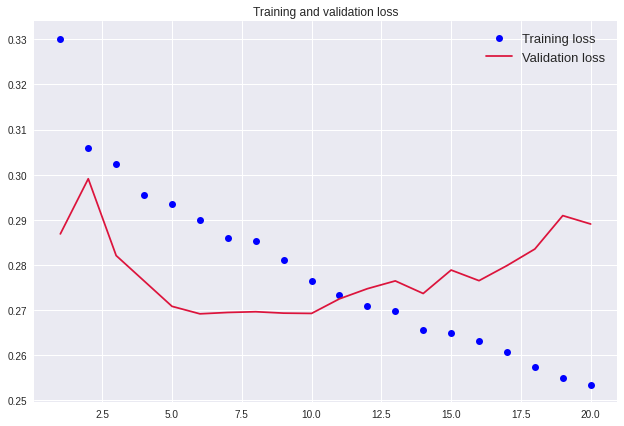

In [ ]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

#### # 스태킹 순환 층 추가
---
- 네트워크를 늘렸지만 크게 개선되지 않았다.
- 비용대비 효율이 너무 낮으면 반드시 네트워크를 추가할 필요는 없다.

In [ ]:
# 모델 훈련 및 검증

model = Sequential()
model.add(GRU(32, 
              dropout = 0.1, 
              recurrent_dropout = 0.5,
              return_sequences = True,
              input_shape = (None, float_data.shape[-1])))
model.add(GRU(64, 
              dropout = 0.1, 
              recurrent_dropout = 0.5,
              input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 40,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 938s 2s/step - loss: 0.3223 - val_loss: 0.3017
Epoch 2/40
500/500 [==============================] - 928s 2s/step - loss: 0.3011 - val_loss: 0.2751
Epoch 3/40
500/500 [==============================] - 932s 2s/step - loss: 0.2888 - val_loss: 0.2737
Epoch 4/40
500/500 [==============================] - 926s 2s/step - loss: 0.2825 - val_loss: 0.2693
Epoch 5/40
500/500 [==============================] - 929s 2s/step - loss: 0.2757 - val_loss: 0.2729
Epoch 6/40
500/500 [==============================] - 931s 2s/step - loss: 0.2697 - val_loss: 0.2699
Epoch 7/40
500/500 [==============================] - 934s 2s/step - loss: 0.2643 - val_loss: 0.2824
Epoch 8/40
500/500 [==============================] - 927s 2s/step - loss: 0.2580 - val_loss: 0.2854
Epoch 9/40
500/500 [==============================] - 925s 2s/step - loss: 0.2519 - val_loss: 0.2865
Epoch 10/40
500/500 [==============================] - 925s 2s/step - loss: 0.2460 - val_lo

KeyboardInterrupt: ignored

In [ ]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

### # 양방향 RNN
---

#### # 시계열 데이터를 역방향으로 돌린 뒤 모델 구성
---

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
                    float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step, 
                    batch_size=batch_size)

val_gen_reverse = reverse_order_generator(
                    float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen_reverse에서 추출할 횟수
# generator() 함수는 while문을 사용하여 무한 반복되기 때문에 검증 세트와 테스트 세트를 한 번 순회하는 횟수를 알려주어야 한다.
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
# 모델 훈련 및 평가

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen_reverse,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen_reverse,
                    validation_steps = val_steps)

In [ ]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()